In [1]:
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import PIL.Image
import numpy as np
from torchvision.utils import make_grid
import PIL.Image

In [2]:
from data import RawWaterMeterDS
from utils import coordinate_rotation_transform, show

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.Size([3, 960, 540])

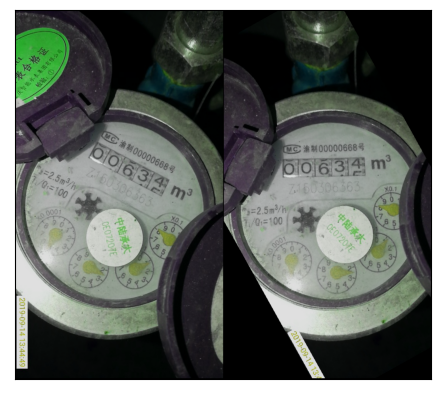

In [4]:
DS = RawWaterMeterDS()
# default RawDataset return (img, rotated angles)
img, ang = DS[2]
show(make_grid([img, transforms.RandomRotation([ang * 90, ang * 90])(img)]))
DS[2][0].shape

In [5]:
from models.RotationRegressionNetwork import rota_reg_net_resnet18
net = rota_reg_net_resnet18()
# net_1 = rota_reg_net_resnet18()
# net_2 = rota_reg_net_resnet18()

In [6]:
from utils import tuple_collate_fn
dl = data.DataLoader(DS, 16, True, collate_fn=tuple_collate_fn)

In [7]:
optim = torch.optim.Adam(net.parameters(), lr=0.00001)
# optim_1 = torch.optim.Adam(net_1.parameters(), lr=0.00001)
# optim_2 = torch.optim.Adam(net_2.parameters(), lr=0.00001)

In [8]:
net.to(device)
net.train()
for epoch in range(20):
    mean_loss = 0
    for i, (X, y) in enumerate(dl):
        optim.zero_grad()
        loss_dict, _ = net(X, y)
        loss = loss_dict['mae_loss']
        mean_loss += loss.item()
        if (i + 1) % 20 == 0:
            print(mean_loss / 20)
            mean_loss = 0
        loss.backward()
        optim.step()

0.4688365399837494
0.19755485318601132
0.16041790395975114
0.1568408366292715
0.14554232284426688
0.14167887158691883
0.12872097529470922
0.12867647558450698
0.11712921187281608
0.12056665681302547
0.11455426029860974
0.10681199170649051
0.11601335592567921
0.10343948975205422
0.1153847899287939
0.10717073827981949
0.0942859921604395
0.10223579593002796
0.09905399456620216
0.09860860295593739
0.09345663562417031
0.09326581358909607
0.10148887243121862
0.08986433185636997
0.08784766588360071
0.08391674272716046
0.09419719465076923
0.08279529511928559
0.07867811173200608
0.08143050689250231
0.0877527803182602
0.0775601064786315
0.08160005379468202
0.07853384725749493
0.07958879470825195
0.08302644845098257


KeyboardInterrupt: 

In [9]:
# test model precision
with torch.no_grad():
    net.eval()
    num_less_5, num_less_10 = 0, 0
    for X, y in dl:
        res = torch.abs(net(X, y) - torch.cat(y, dim=0).to(device) * 90)
        num_less_10 += (res < 10.0).sum()
        num_less_5 += (res < 5.0).sum()
    print(num_less_10 / 1000, num_less_5 / 1000)

tensor(0.7570, device='cuda:0') tensor(0.4610, device='cuda:0')


In [ ]:
TDS = RawWaterMeterDS('test')
# for _ in range(500):
#     img = transforms.ToTensor()(PIL.Image.open(f'WaterMeterDataset/test_imgs/test_imgs/test_{_ + 1}.jpg'))
#     rot = net(img)
#     img = transforms.RandomRotation([rot, rot])(img)
#     img = transforms.ToPILImage()(img)
#     img.save(f'WaterMeterDataset/ProcessedData/test_imgs/test_imgs/test_{_ + 1}.jpg')
with torch.no_grad():
    num_iters = 5
    for it in range(num_iters):
        for _ in range(500):
            img = transforms.ToTensor()(PIL.Image.open(f'WaterMeterDataset/ProcessedData/test_imgs/test_imgs/test_{_ + 1}.jpg'))
            rot = net(img)
            img = transforms.RandomRotation([rot, rot])(img)
            img = transforms.ToPILImage()(img)
            img.save(f'WaterMeterDataset/ProcessedData/test_imgs/test_imgs/test_{_ + 1}.jpg')

In [ ]:
def trans(target):
    ts = target.split()
    coordinate_list = [int(str_digit) for str_digit in ts[0: 8]]
    x_0, y_0, x_1, y_1 = coordinate_list[0: 4]
    if (x_1 - x_0) == 0:
        return torch.tensor([[1.0]])
    k = (y_1 - y_0) / (x_1 - x_0)
    angel = torch.atan(torch.tensor([[k]])) / torch.pi * 180.0 / 90.0

    return angel, coordinate_list, ts[8: ]

In [ ]:
TTDS = RawWaterMeterDS('train', root='WaterMeterDataset', target_transform=trans)

In [ ]:
for idx in range(1000):
    img = TTDS[idx][0]
    rot = TTDS[idx][1][0] * 90
    central_posi = (TTDS[idx][0].shape[1] // 2, TTDS[idx][0].shape[2] // 2)
    coors = coordinate_rotation_transform(TTDS[idx][1][1], central_posi, rot, swap_xy=False).to(torch.int)
    digits = ''
    for i in TTDS[idx][1][2]:
        digits += i + ' '
    f = open(f'WaterMeterDataset/ProcessedData/train_labels/labels/train_{idx + 1}.txt', mode='w')
    f.write(str(coors.numpy())[1: -1] + ' ' + digits)
    f.close()
    img = transforms.ToPILImage()(img)
    img.save(f'WaterMeterDataset/ProcessedData/train_imgs/train_{idx + 1}.jpg')